# GMM(Gaussian mixture model)
利用高斯混合模型进行聚类

## 参考文献
[1] 《统计学习方法》 李航 P157-160 <br>
[2] 《机器学习》（西瓜书）P210<br>
[3] 南瓜书PumpkinBook <br>
[4] https://blog.csdn.net/lin_limin/article/details/81048411

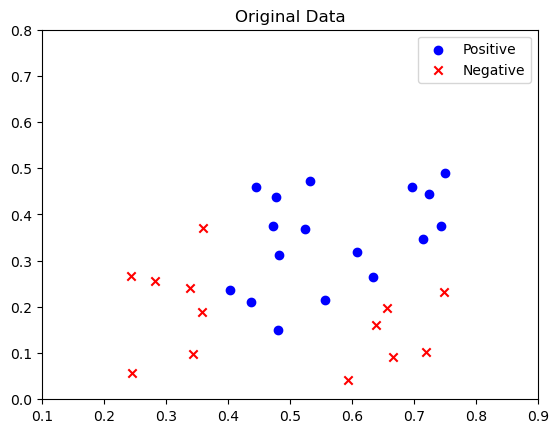

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

with open('wm4.csv', 'r') as file_object:
    X = pd.read_csv(file_object, header=None).values
    
m,d = X.shape  # 样本个数与样本维数
Y = np.ones(m)
Y[8:20] = 0

X_pos = np.concatenate((X[0:8,:], X[21:30,:]), axis=0)
X_neg = X[8:21,:]
plt.scatter(X_pos[:,0], X_pos[:,1], color='blue', marker='o', label='Positive')
plt.scatter(X_neg[:,0], X_neg[:,1], color='red', marker='x', label='Negative')

#plt.axis('square')
plt.legend(loc='upper right')
plt.title('Original Data')
plt.axis([0.1, 0.9, 0, 0.8])
plt.show()

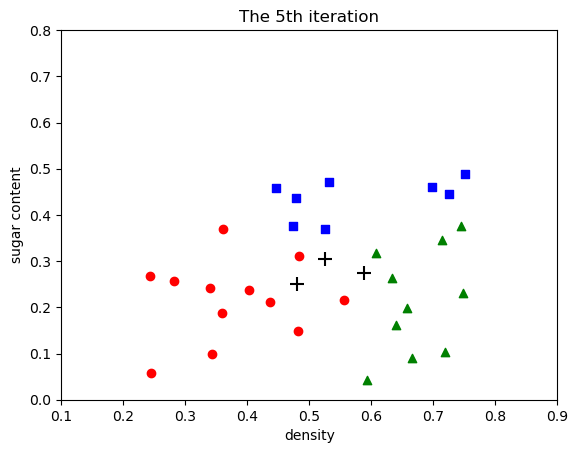

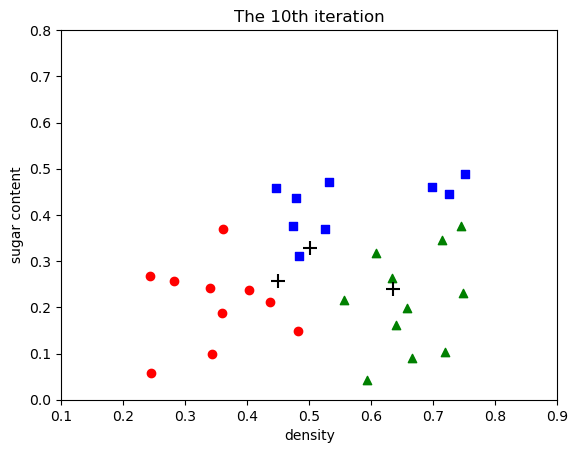

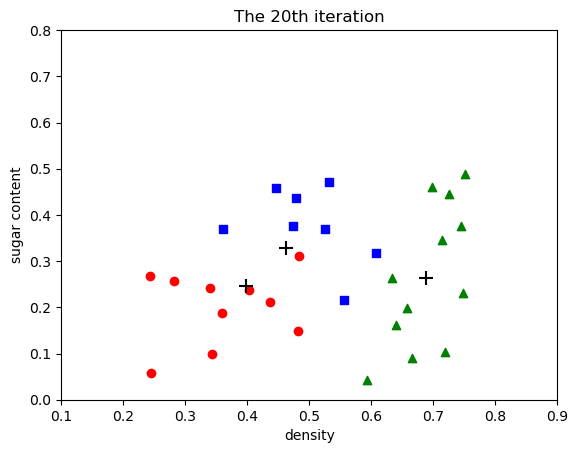

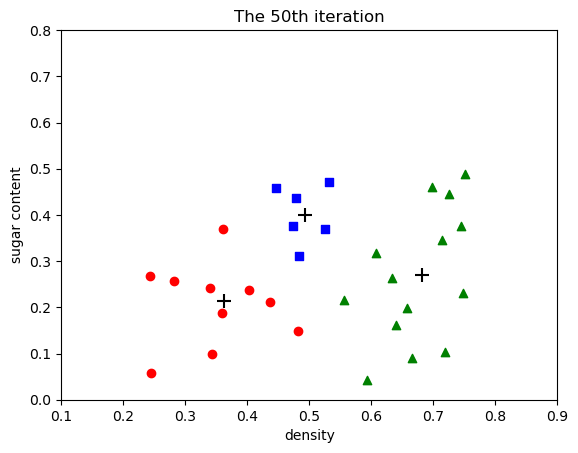

In [103]:
class GMM():
    def __init__(self, k, X):
        self.X = X
        self.m = X.shape[0]  # 样本个数
        self.d = X.shape[1]  # 样本维数
        self.k = k  # 混合成分个数
        self.covM = np.zeros((self.k, self.d, self.d))  # 协方差矩阵
        self.mu = np.zeros((self.k, self.d))
        self.alphas = np.zeros(self.k)  # 混合系数
        self.gamma = np.zeros((self.m, self.k))  # 隐变量，样本j属于i分布的后验概率
        self.parameter_init()
        
    def parameter_init(self):
        choice = np.random.choice(self.m, self.k, replace=False)  # 任选训练集中的k个样本分别初始化k个均值向量µi
        for i in range(self.k):
            self.covM[i] = np.diag([0.1 for _ in range(self.d)])
            self.alphas[i] = 1 / self.k
            self.mu[i] = self.X[choice[i]]
        self.mu[0] = self.X[5]
        self.mu[1] = self.X[21]
        self.mu[2] = self.X[26]
        
    def gauss_density_probability(self, x, mu, sigma):
        sigma_det = np.linalg.det(sigma)
        divisor = np.power(2 * np.pi, self.d / 2) * np.sqrt(sigma_det)
        exp = np.exp(-0.5 * (x - mu)[:,np.newaxis].T @ np.linalg.inv(sigma) @ (x - mu)[:,np.newaxis])
        p = exp[0][0] / divisor
        return p
        
    def posterior_p(self, i, xj, mu, sigma, alphas):
        p = [alphas[j] * self.gauss_density_probability(xj, mu[j], sigma[j]) for j in range(self.k)]
        return p[i] / np.sum(p)
    
    def cal_gamma(self):
        for j in range(self.m):
            for i in range(self.k):
                self.gamma[j,i] = self.posterior_p(i, self.X[j], self.mu, self.covM, self.alphas)
                
    def EM(self, epochs):
        for epoch in range(1, epochs + 1):
            self.cal_gamma()  # E步，推断隐变量Z的值
            for i in range(self.k):  # M步，MLE估计参数
                gammaj_sum = 0
                gammaXj_sum = 0
                for j in range(self.m):
                    gammaj_sum += self.gamma[j,i]
                    gammaXj_sum += self.gamma[j,i] * self.X[j]
                self.mu[i] = gammaXj_sum / gammaj_sum  # 新均值向量
                
                gammaCov_sum = 0
                for j in range(self.m):
                    Covji = (self.X[j] - self.mu[i])[:, np.newaxis] @ (self.X[j] - self.mu[i])[:, np.newaxis].T
                    gammaCov_sum += self.gamma[j,i] * Covji
                self.covM[i] = gammaCov_sum / gammaj_sum  # 新协方差矩阵
                
                self.alphas[i] = gammaj_sum / self.m  # 新混合系数
            
            if epoch in [5,10,20,50]:
                self.predict()
                plt.axis([0.1, 0.9, 0, 0.8])
                plt.xlabel("density")
                plt.ylabel("sugar content")
                plt.title(f"The {epoch}th iteration")
                plt.show()
                
    def predict(self):
        color = ['r', 'g', 'b']
        marker = ['o', '^', 's']
        for j in range(self.m):
            o = np.argmax(self.gamma[j])
            plt.scatter(self.X[j,0], self.X[j,1], c=color[o], marker=marker[o])
        
        for i in range(self.k):
            plt.scatter(self.mu[i,0], self.mu[i,1], c='k', marker='+', s=100)
        
np.random.seed(3)
a = GMM(3,X)
a.EM(100)